# Brain Tumors Classification with Texture Analysis of MRI Images

### Import Required Modules

In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import random
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

### Load Dataset

In [2]:
def load_images(directory):
    imgs = []
    labels = []
    for folder in os.listdir(directory):
        files = os.listdir(os.path.join(directory, folder))
        for i, filename in enumerate(files):
            img = cv2.imread(os.path.join(directory, folder, filename))
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            imgs.append(gray_img)
            labels.append(folder)
    return imgs, labels

In [3]:
dataset_directory = "dataset/"
imgs, labels = load_images(dataset_directory)
# plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))

### Extract Texture Properties

In [4]:
def glcm_features(img, label, properties=["contrast"]):
    glcm_matrix = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    features = []
    for property in properties:
        glcm_property_matrix = graycoprops(glcm_matrix, property)[0]
        features = np.concatenate((features, glcm_property_matrix))
    features = np.append(features, label)
    return features

def imgs2glcmdf(imgs, labels, properties=["contrast"]):
    features_data = []
    columns = []
    len_data = len(labels)
    count = 0
    for img, label in zip(imgs, labels): 
        features_data.append(glcm_features(img, label, properties))
        count += 1
        if count%1000==0 or count==len_data:
            print(f"Done extracting from {count}/{len_data} image(s)")
    angles = ["0", "45", "90", "135"]
    for property in properties :
        for angle in angles:
            columns.append(property + "_" + angle)
    columns.append("label")
    glcm_df = pd.DataFrame(features_data, columns=columns)
    return glcm_df

In [5]:
glcm_df = imgs2glcmdf(imgs, labels, ["contrast", "dissimilarity", "homogeneity", "ASM", "energy", "correlation"])

Done extracting from 1000/7023 image(s)
Done extracting from 2000/7023 image(s)
Done extracting from 3000/7023 image(s)
Done extracting from 4000/7023 image(s)
Done extracting from 5000/7023 image(s)
Done extracting from 6000/7023 image(s)
Done extracting from 7000/7023 image(s)
Done extracting from 7023/7023 image(s)


### Save to csv

In [6]:
glcm_df.to_csv("csv/brain_tumor_texture_dataset.csv")

### Load csv

In [7]:
glcm_df = pd.read_csv("csv/brain_tumor_texture_dataset.csv", index_col=0)
glcm_df.head()
# glcm_df.iloc[[0]].T

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,ASM_135,energy_0,energy_45,energy_90,energy_135,correlation_0,correlation_45,correlation_90,correlation_135,label
0,43.502783,74.696888,41.759892,83.532922,2.764280,3.743881,2.790125,3.883602,0.620115,0.574687,...,0.104631,0.328315,0.323507,0.330025,0.323468,0.986142,0.976224,0.986697,0.973412,glioma
1,47.678120,81.362924,40.278253,85.304882,2.475118,3.234631,2.198752,3.356329,0.681983,0.632466,...,0.115034,0.344297,0.339058,0.345594,0.339166,0.980536,0.966808,0.983557,0.965200,glioma
2,40.397505,70.937757,35.279308,72.150191,2.699211,3.576802,2.486607,3.606252,0.657221,0.619269,...,0.112327,0.340486,0.335081,0.341753,0.335152,0.986231,0.975843,0.987975,0.975430,glioma
3,26.931438,46.371211,21.594671,46.141279,2.126468,2.774335,1.795159,2.791721,0.679452,0.640995,...,0.092083,0.310570,0.303471,0.314125,0.303452,0.988560,0.980320,0.990827,0.980418,glioma
4,43.594568,73.020106,34.425915,76.107134,2.750849,3.647003,2.389597,3.689657,0.625021,0.576710,...,0.067748,0.265323,0.260208,0.268096,0.260285,0.983932,0.973107,0.987315,0.971970,glioma


### Preprocess Data and Split to Data

In [8]:
def decimal_scaling(data):
    data = np.array(data, dtype=np.float32)
    maxes = data.max(axis=0)
    c = np.array([])
    for max in np.abs(maxes):
        c = np.append(c, len(str(int(max))))
    return data/(10**c)

def splitXY(df, attributes, label):
    le = LabelEncoder()
    X = decimal_scaling(df.loc[:, attributes].values)
#     X = np.array(df.loc[:, attributes].values, dtype=np.float32)
    Y = le.fit_transform(df[label].values)
    return X, Y

In [9]:
attributes = glcm_df.columns[:-1]
label = glcm_df.columns[-1]
X, Y = splitXY(glcm_df, attributes, label)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=112)

### Create and Train Model

In [11]:
def nn_model():
    
    model = Sequential()
    model.add(Dense(32, activation="elu", input_shape=(24,)))
    model.add(Dense(1024, activation="elu"))
    model.add(Dense(512, activation="elu"))
    model.add(Dense(256, activation="elu"))
    model.add(Dense(128, activation="elu"))
    model.add(Dense(4, activation="softmax"))
    
    model.summary() 
    
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])

    return model

In [12]:
model = nn_model()
history = model.fit(X_train, y_train, epochs=1000, batch_size=100, validation_data=(X_test, y_test))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                800       
                                                                 
 dense_1 (Dense)             (None, 1024)              33792     
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 724132 (2.76 MB)
Trainable params: 724132

Epoch 43/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.5855 - accuracy: 0.7547 - val_loss: 0.6395 - val_accuracy: 0.7224
Epoch 44/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.6155 - accuracy: 0.7446 - val_loss: 0.6445 - val_accuracy: 0.7388
Epoch 45/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.6059 - accuracy: 0.7471 - val_loss: 0.6269 - val_accuracy: 0.7281
Epoch 46/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.5903 - accuracy: 0.7526 - val_loss: 0.6185 - val_accuracy: 0.7644
Epoch 47/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.5869 - accuracy: 0.7563 - val_loss: 0.5721 - val_accuracy: 0.7566
Epoch 48/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.5632 - accuracy: 0.7659 - val_loss: 0.5862 - val_accuracy: 0.7623
Epoch 49/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.5720 - accuracy: 0.7633 - val_loss: 0.6079 - val_accuracy: 0.7260

57/57 [==============================] - 0s 7ms/step - loss: 0.4536 - accuracy: 0.8117 - val_loss: 0.6178 - val_accuracy: 0.7915
Epoch 101/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4744 - accuracy: 0.8065 - val_loss: 0.4601 - val_accuracy: 0.8142
Epoch 102/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4478 - accuracy: 0.8143 - val_loss: 0.5304 - val_accuracy: 0.7936
Epoch 103/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4646 - accuracy: 0.8062 - val_loss: 0.5751 - val_accuracy: 0.7658
Epoch 104/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4513 - accuracy: 0.8138 - val_loss: 0.4581 - val_accuracy: 0.8164
Epoch 105/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4449 - accuracy: 0.8168 - val_loss: 0.5151 - val_accuracy: 0.7993
Epoch 106/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4648 - accuracy: 0.8104 - val_loss: 0.4557 - val_accuracy: 0.8199
Epoch 1

Epoch 157/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3756 - accuracy: 0.8455 - val_loss: 0.4923 - val_accuracy: 0.8221
Epoch 158/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3767 - accuracy: 0.8421 - val_loss: 0.4352 - val_accuracy: 0.8263
Epoch 159/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3514 - accuracy: 0.8556 - val_loss: 0.3733 - val_accuracy: 0.8477
Epoch 160/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3607 - accuracy: 0.8492 - val_loss: 0.4142 - val_accuracy: 0.8370
Epoch 161/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3612 - accuracy: 0.8483 - val_loss: 0.5440 - val_accuracy: 0.7779
Epoch 162/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4369 - accuracy: 0.8197 - val_loss: 0.4966 - val_accuracy: 0.8128
Epoch 163/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.4018 - accuracy: 0.8318 - val_loss: 0.4257 - val_accuracy:

Epoch 214/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3019 - accuracy: 0.8750 - val_loss: 0.3730 - val_accuracy: 0.8612
Epoch 215/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3266 - accuracy: 0.8644 - val_loss: 0.4443 - val_accuracy: 0.8256
Epoch 216/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3331 - accuracy: 0.8569 - val_loss: 0.4113 - val_accuracy: 0.8413
Epoch 217/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.8779 - val_loss: 0.3625 - val_accuracy: 0.8754
Epoch 218/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3035 - accuracy: 0.8749 - val_loss: 0.4538 - val_accuracy: 0.8406
Epoch 219/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3927 - accuracy: 0.8428 - val_loss: 0.4818 - val_accuracy: 0.8199
Epoch 220/1000
57/57 [==============================] - 0s 8ms/step - loss: 0.3437 - accuracy: 0.8596 - val_loss: 0.3820 - val_accuracy:

Epoch 271/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2446 - accuracy: 0.8957 - val_loss: 0.3983 - val_accuracy: 0.8584
Epoch 272/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3343 - accuracy: 0.8645 - val_loss: 0.4557 - val_accuracy: 0.8491
Epoch 273/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2804 - accuracy: 0.8861 - val_loss: 0.3503 - val_accuracy: 0.8740
Epoch 274/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2449 - accuracy: 0.8946 - val_loss: 0.3689 - val_accuracy: 0.8598
Epoch 275/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2530 - accuracy: 0.8921 - val_loss: 0.4188 - val_accuracy: 0.8463
Epoch 276/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2411 - accuracy: 0.9009 - val_loss: 0.4146 - val_accuracy: 0.8420
Epoch 277/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2400 - accuracy: 0.8991 - val_loss: 0.4136 - val_accuracy:

Epoch 328/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2299 - accuracy: 0.9042 - val_loss: 0.3630 - val_accuracy: 0.8854
Epoch 329/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2073 - accuracy: 0.9126 - val_loss: 0.3847 - val_accuracy: 0.8726
Epoch 330/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2559 - accuracy: 0.8934 - val_loss: 0.3703 - val_accuracy: 0.8769
Epoch 331/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2312 - accuracy: 0.9048 - val_loss: 0.3929 - val_accuracy: 0.8676
Epoch 332/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1993 - accuracy: 0.9153 - val_loss: 0.3655 - val_accuracy: 0.8826
Epoch 333/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2353 - accuracy: 0.9012 - val_loss: 0.4411 - val_accuracy: 0.8448
Epoch 334/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2213 - accuracy: 0.9041 - val_loss: 0.3741 - val_accuracy:

Epoch 385/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1863 - accuracy: 0.9188 - val_loss: 0.6898 - val_accuracy: 0.7865
Epoch 386/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2886 - accuracy: 0.8852 - val_loss: 0.4297 - val_accuracy: 0.8541
Epoch 387/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2086 - accuracy: 0.9126 - val_loss: 0.4589 - val_accuracy: 0.8399
Epoch 388/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2465 - accuracy: 0.9010 - val_loss: 0.3641 - val_accuracy: 0.8783
Epoch 389/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1915 - accuracy: 0.9210 - val_loss: 0.3775 - val_accuracy: 0.8740
Epoch 390/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2104 - accuracy: 0.9099 - val_loss: 0.3363 - val_accuracy: 0.8861
Epoch 391/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2058 - accuracy: 0.9140 - val_loss: 0.5671 - val_accuracy:

Epoch 442/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2374 - accuracy: 0.9010 - val_loss: 1.0321 - val_accuracy: 0.7630
Epoch 443/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.3391 - accuracy: 0.8724 - val_loss: 0.4147 - val_accuracy: 0.8762
Epoch 444/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1870 - accuracy: 0.9217 - val_loss: 0.4057 - val_accuracy: 0.8698
Epoch 445/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1641 - accuracy: 0.9327 - val_loss: 0.3944 - val_accuracy: 0.8698
Epoch 446/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1722 - accuracy: 0.9297 - val_loss: 0.4190 - val_accuracy: 0.8676
Epoch 447/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1663 - accuracy: 0.9295 - val_loss: 0.4012 - val_accuracy: 0.8804
Epoch 448/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1754 - accuracy: 0.9252 - val_loss: 0.4101 - val_accuracy:

Epoch 499/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2391 - accuracy: 0.9030 - val_loss: 0.3775 - val_accuracy: 0.8847
Epoch 500/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9395 - val_loss: 0.3661 - val_accuracy: 0.8847
Epoch 501/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1304 - accuracy: 0.9443 - val_loss: 0.3617 - val_accuracy: 0.8968
Epoch 502/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1326 - accuracy: 0.9405 - val_loss: 0.3920 - val_accuracy: 0.8911
Epoch 503/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1674 - accuracy: 0.9295 - val_loss: 0.3950 - val_accuracy: 0.8655
Epoch 504/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9318 - val_loss: 0.3329 - val_accuracy: 0.9018
Epoch 505/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1897 - accuracy: 0.9254 - val_loss: 0.4633 - val_accuracy:

Epoch 556/1000
57/57 [==============================] - 0s 8ms/step - loss: 0.1111 - accuracy: 0.9550 - val_loss: 0.3901 - val_accuracy: 0.8826
Epoch 557/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1873 - accuracy: 0.9231 - val_loss: 0.3586 - val_accuracy: 0.8897
Epoch 558/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1474 - accuracy: 0.9397 - val_loss: 0.3946 - val_accuracy: 0.8769
Epoch 559/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1778 - accuracy: 0.9249 - val_loss: 0.5238 - val_accuracy: 0.8534
Epoch 560/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1483 - accuracy: 0.9397 - val_loss: 0.3455 - val_accuracy: 0.8904
Epoch 561/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9384 - val_loss: 0.3997 - val_accuracy: 0.8819
Epoch 562/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1623 - accuracy: 0.9292 - val_loss: 0.4131 - val_accuracy:

Epoch 613/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1229 - accuracy: 0.9503 - val_loss: 0.3941 - val_accuracy: 0.8840
Epoch 614/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.9402 - val_loss: 0.4347 - val_accuracy: 0.8811
Epoch 615/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1395 - accuracy: 0.9420 - val_loss: 0.3630 - val_accuracy: 0.8975
Epoch 616/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.9587 - val_loss: 0.4391 - val_accuracy: 0.8897
Epoch 617/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2129 - accuracy: 0.9099 - val_loss: 0.4231 - val_accuracy: 0.8655
Epoch 618/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1677 - accuracy: 0.9231 - val_loss: 0.4334 - val_accuracy: 0.8790
Epoch 619/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1577 - accuracy: 0.9318 - val_loss: 0.4230 - val_accuracy:

Epoch 670/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9575 - val_loss: 0.4102 - val_accuracy: 0.8911
Epoch 671/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.9457 - val_loss: 0.4479 - val_accuracy: 0.8861
Epoch 672/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2851 - accuracy: 0.8984 - val_loss: 0.4326 - val_accuracy: 0.8797
Epoch 673/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1499 - accuracy: 0.9375 - val_loss: 0.4170 - val_accuracy: 0.8819
Epoch 674/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.9612 - val_loss: 0.3773 - val_accuracy: 0.8947
Epoch 675/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1030 - accuracy: 0.9575 - val_loss: 0.4135 - val_accuracy: 0.8797
Epoch 676/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1615 - accuracy: 0.9306 - val_loss: 0.4258 - val_accuracy:

Epoch 727/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1254 - accuracy: 0.9505 - val_loss: 0.5932 - val_accuracy: 0.8505
Epoch 728/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1771 - accuracy: 0.9340 - val_loss: 0.3822 - val_accuracy: 0.8875
Epoch 729/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9528 - val_loss: 0.4124 - val_accuracy: 0.8890
Epoch 730/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0986 - accuracy: 0.9587 - val_loss: 0.3750 - val_accuracy: 0.8875
Epoch 731/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0999 - accuracy: 0.9596 - val_loss: 0.3778 - val_accuracy: 0.8961
Epoch 732/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0829 - accuracy: 0.9656 - val_loss: 0.3824 - val_accuracy: 0.9060
Epoch 733/1000
57/57 [==============================] - 0s 8ms/step - loss: 0.1573 - accuracy: 0.9368 - val_loss: 0.4549 - val_accuracy:

Epoch 784/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.9432 - val_loss: 0.3870 - val_accuracy: 0.8975
Epoch 785/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1241 - accuracy: 0.9473 - val_loss: 0.5422 - val_accuracy: 0.8662
Epoch 786/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1846 - accuracy: 0.9306 - val_loss: 0.4995 - val_accuracy: 0.8534
Epoch 787/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.9511 - val_loss: 0.4434 - val_accuracy: 0.8847
Epoch 788/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1206 - accuracy: 0.9518 - val_loss: 0.4515 - val_accuracy: 0.8925
Epoch 789/1000
57/57 [==============================] - 0s 8ms/step - loss: 0.1001 - accuracy: 0.9591 - val_loss: 0.4139 - val_accuracy: 0.8911
Epoch 790/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9551 - val_loss: 0.5112 - val_accuracy:

Epoch 841/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1004 - accuracy: 0.9573 - val_loss: 0.4661 - val_accuracy: 0.8833
Epoch 842/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1534 - accuracy: 0.9409 - val_loss: 0.4484 - val_accuracy: 0.8676
Epoch 843/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1163 - accuracy: 0.9489 - val_loss: 0.4014 - val_accuracy: 0.9082
Epoch 844/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9587 - val_loss: 0.4560 - val_accuracy: 0.8719
Epoch 845/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1442 - accuracy: 0.9425 - val_loss: 0.4975 - val_accuracy: 0.8726
Epoch 846/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1780 - accuracy: 0.9320 - val_loss: 0.4248 - val_accuracy: 0.8826
Epoch 847/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0903 - accuracy: 0.9617 - val_loss: 0.3894 - val_accuracy:

Epoch 898/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2122 - accuracy: 0.9174 - val_loss: 0.4539 - val_accuracy: 0.8819
Epoch 899/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1383 - accuracy: 0.9439 - val_loss: 0.4766 - val_accuracy: 0.8776
Epoch 900/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0849 - accuracy: 0.9658 - val_loss: 0.3945 - val_accuracy: 0.8947
Epoch 901/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0937 - accuracy: 0.9614 - val_loss: 0.4124 - val_accuracy: 0.9039
Epoch 902/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0798 - accuracy: 0.9662 - val_loss: 0.4231 - val_accuracy: 0.8940
Epoch 903/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1730 - accuracy: 0.9365 - val_loss: 0.5140 - val_accuracy: 0.8754
Epoch 904/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.2015 - accuracy: 0.9245 - val_loss: 0.4047 - val_accuracy:

Epoch 955/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0936 - accuracy: 0.9621 - val_loss: 0.4062 - val_accuracy: 0.9004
Epoch 956/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.9610 - val_loss: 0.3977 - val_accuracy: 0.8975
Epoch 957/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.9616 - val_loss: 0.5031 - val_accuracy: 0.8683
Epoch 958/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.9381 - val_loss: 0.4415 - val_accuracy: 0.8868
Epoch 959/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0984 - accuracy: 0.9607 - val_loss: 0.3797 - val_accuracy: 0.9018
Epoch 960/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0519 - accuracy: 0.9813 - val_loss: 0.3828 - val_accuracy: 0.8996
Epoch 961/1000
57/57 [==============================] - 0s 7ms/step - loss: 0.0477 - accuracy: 0.9808 - val_loss: 0.4300 - val_accuracy:

### Save Model

In [13]:
model.save("model/model.keras")
with open("model/history.pkl", "wb") as file:
    pickle.dump(history.history, file)

### Load Model

In [14]:
model = load_model("model/model.keras")

### Evaluate Performance

In [15]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

44/44 [==============================] - 0s 2ms/step
Accuracy: 0.9096085409252669
Precision: 0.9079265513267569
Recall: 0.9073282840727198


### Examples

In [29]:
class_map = {
    0: "glioma",
    1: "meningioma",
    2: "notumor",
    3: "pituitary"
}

1/1 [==============================] - 0s 18ms/step


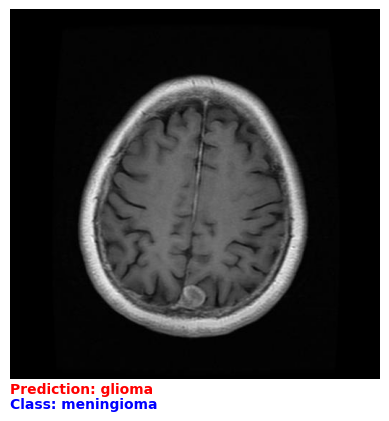

<Figure size 25600x25600 with 0 Axes>

In [76]:
i = random.randint(0, 7022)
xi = X[i].reshape(1, 24)
yi_prob = model.predict(xi)
yi_pred = np.argmax(yi_prob, axis=1)

pred_label = "Prediction: " + class_map[yi_pred[0]]
class_label = "Class: " + class_map[Y[i]]
plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
plt.text(0, imgs[i].shape[0]+20, pred_label, color='red', fontsize=10, fontweight='bold')
plt.text(0, imgs[i].shape[0]+40, class_label, color='blue', fontsize=10, fontweight='bold')
plt.axis("off")
plt.figure(figsize=(256, 256))
plt.show()